# Restormer

Original Author: [Syed Waqas Zamir](https://github.com/swz30)

Provided by: [BreezeWhite](https://github.com/BreezeWhite)

Original Github: https://github.com/swz30/Restormer

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BreezeWhite/interesting-colabs/blob/main/scripts/Restormer.ipynb)

In [1]:
#@title Setup

!pip install einops
!git clone https://github.com/swz30/Restormer.git
%cd Restormer

!wget https://github.com/swz30/Restormer/releases/download/v1.0/real_denoising.pth -P Denoising/pretrained_models
!wget https://github.com/swz30/Restormer/releases/download/v1.0/single_image_defocus_deblurring.pth -P Defocus_Deblurring/pretrained_models
!wget https://github.com/swz30/Restormer/releases/download/v1.0/motion_deblurring.pth -P Motion_Deblurring/pretrained_models
!wget https://github.com/swz30/Restormer/releases/download/v1.0/deraining.pth -P Deraining/pretrained_models

def get_weights_and_parameters(task, parameters):
  if task == 'Motion_Deblurring':
    weights = 'Motion_Deblurring/pretrained_models/motion_deblurring.pth'
  elif task == 'Single_Image_Defocus_Deblurring':
    weights = 'Defocus_Deblurring/pretrained_models/single_image_defocus_deblurring.pth'
  elif task == 'Deraining':
    weights = 'Deraining/pretrained_models/deraining.pth'
  elif task == 'Real_Denoising':
    weights = 'Denoising/pretrained_models/real_denoising.pth'
    parameters['LayerNorm_type'] =  'BiasFree'
  return weights, parameters


import os
import torch
import torch.nn.functional as F
from PIL import Image
from runpy import run_path


MAX_PXS = 900**2
def load_image(img_path):
  img = Image.open(img_name).convert('RGB')
  w, h = img.size
  pxs = w * h
  if pxs > MAX_PXS:
    ratio = MAX_PXS / pxs
    ratio = pow(ratio, 0.5)
    tar_w = int(ratio * w)
    tar_h = int(ratio * h)
    img = img.resize((tar_w, tar_h))
  return np.array(img)


def get_model(task, parameters):
  weights, parameters = get_weights_and_parameters(task, parameters)
  load_arch = run_path(os.path.join('basicsr', 'models', 'archs', 'restormer_arch.py'))
  model = load_arch['Restormer'](**parameters)
  model.cuda()
  checkpoint = torch.load(weights)
  model.load_state_dict(checkpoint['params'])
  model.eval()
  return model


def pad_input(input_, img_multiple_of=8):
  h, w = input_.shape[2], input_.shape[3]
  H = ((h + img_multiple_of) // img_multiple_of) * img_multiple_of
  W = ((w + img_multiple_of) // img_multiple_of) * img_multiple_of
  padh = H - h if h % img_multiple_of != 0 else 0
  padw = W - w if w % img_multiple_of != 0 else 0
  return F.pad(input_, (0, padw, 0, padh), 'reflect')


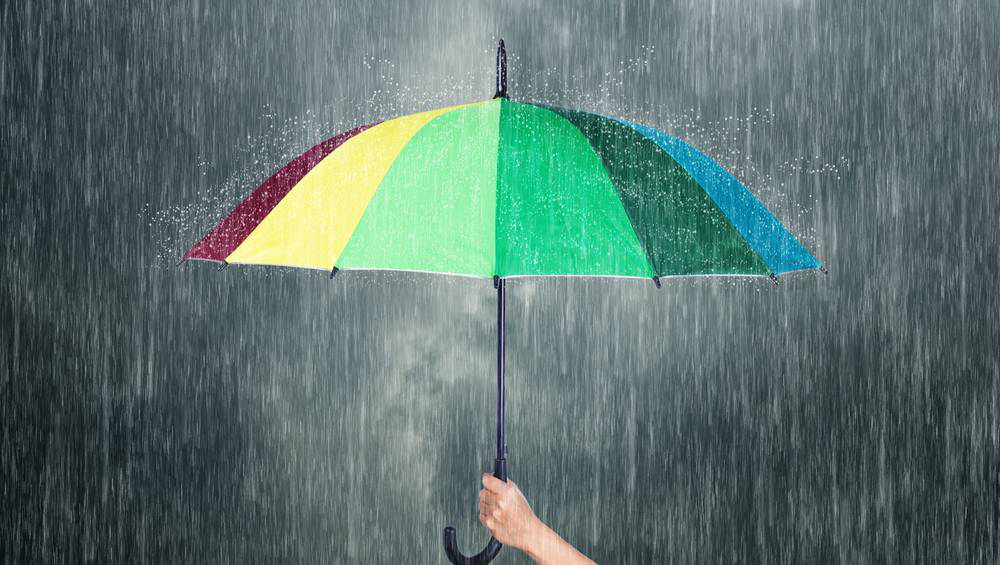

In [29]:
#@title Upload Image

from google.colab import files
from IPython.display import display
from PIL import Image


ff = files.upload()
img_name = list(ff.keys())[0]
display(Image.open(img_name))

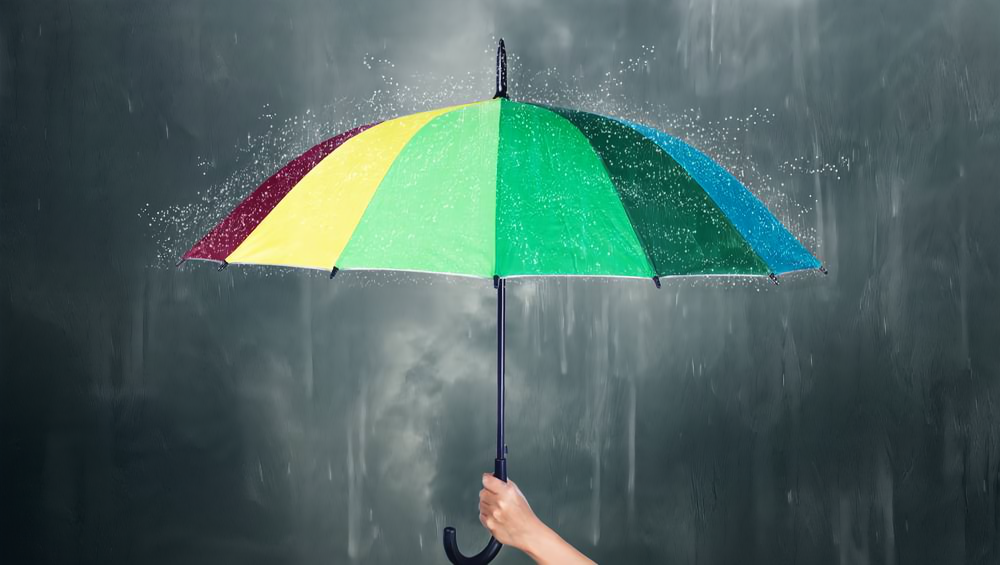

In [28]:
#@title Run

import cv2
import numpy as np
from skimage import img_as_ubyte


task = 'deraining' #@param ['denoising', 'defocus', 'motion_deblurring', 'deraining']
task = {
    'denoising': 'Real_Denoising',
    'defocus': 'Single_Image_Defocus_Deblurring',
    'motion_deblurring': 'Motion_Deblurring',
    'deraining': 'Deraining'
}[task]


parameters = {
  'inp_channels': 3,
  'out_channels': 3,
  'dim': 48,
  'num_blocks': [4, 6, 6, 8],
  'num_refinement_blocks': 4,
  'heads': [1, 2, 4, 8],
  'ffn_expansion_factor': 2.66,
  'bias': False,
  'LayerNorm_type': 'WithBias',
  'dual_pixel_task': False
}
model = get_model(task, parameters)

# Load and resize image to prevent GPU out of memory.
img = load_image(img_name)

with torch.no_grad():
  torch.cuda.ipc_collect()
  torch.cuda.empty_cache()
  input_ = torch.from_numpy(img).float().div(255.).permute(2, 0, 1).unsqueeze(0).cuda()
  input_ = pad_input(input_)

  restored = model(input_)
  restored = torch.clamp(restored, 0, 1)

# Unpad the output
h, w = img.shape[:2]
restored = restored[:, :, :h, :w]
restored = restored.permute(0, 2, 3, 1).cpu().detach().numpy()
restored = img_as_ubyte(restored[0])

display(Image.fromarray(restored))